In [1]:
import sys
import pathlib
import os
from skmap.catalog import DataCatalog
from skmap.loader import TiledDataLoader
from skmap.overlay import SpaceOverlay, SpaceTimeOverlay
from skmap.misc import find_files, GoogleSheet, ttprint
import random
import pandas as pd
import time
import skmap_bindings as sb
import numpy as np
import warnings

df = pd.read_parquet('/home/xuemeng/work_xuemeng/global-soil-mapping/material/ovelayed_socd.ph.lc_change.pq')
print(df.shape)

keep_col = ['id', 'lat', 'lon', 'stratum',
            'lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052',
            'lc_glad.glcluc.change_c_30m_s_20000101_20201231_go_epsg.4326_v20230901',
            'oc_iso.10694.1995.mg.cm3_m_30m_b0cm..30cm_20000101_20051231_g_epsg.4326_v20250204',
            'oc_iso.10694.1995.mg.cm3_m_30m_b0cm..30cm_20050101_20101231_g_epsg.4326_v20250204',
            'oc_iso.10694.1995.mg.cm3_m_30m_b0cm..30cm_20100101_20151231_g_epsg.4326_v20250204',
            'oc_iso.10694.1995.mg.cm3_m_30m_b0cm..30cm_20150101_20201231_g_epsg.4326_v20250204',
            'oc_iso.10694.1995.mg.cm3_m_30m_b0cm..30cm_20200101_20221231_g_epsg.4326_v20250204',
            'ph.h2o_iso.10390.2021.index_m_30m_b0cm..30cm_20000101_20051231_g_epsg.4326_v20250204',
            'ph.h2o_iso.10390.2021.index_m_30m_b0cm..30cm_20050101_20101231_g_epsg.4326_v20250204',
            'ph.h2o_iso.10390.2021.index_m_30m_b0cm..30cm_20100101_20151231_g_epsg.4326_v20250204',
            'ph.h2o_iso.10390.2021.index_m_30m_b0cm..30cm_20150101_20201231_g_epsg.4326_v20250204',
            'ph.h2o_iso.10390.2021.index_m_30m_b0cm..30cm_20200101_20221231_g_epsg.4326_v20250204']
df = df[keep_col].reset_index(drop=True)
warnings.filterwarnings("ignore")
df['socd_change'] = df['oc_iso.10694.1995.mg.cm3_m_30m_b0cm..30cm_20200101_20221231_g_epsg.4326_v20250204'] - df['oc_iso.10694.1995.mg.cm3_m_30m_b0cm..30cm_20000101_20051231_g_epsg.4326_v20250204']
df['ph.h2o_change'] = df['ph.h2o_iso.10390.2021.index_m_30m_b0cm..30cm_20200101_20221231_g_epsg.4326_v20250204'] - df['ph.h2o_iso.10390.2021.index_m_30m_b0cm..30cm_20000101_20051231_g_epsg.4326_v20250204']
print(df.shape)

df = df.dropna(subset = ['lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052',
                          'oc_iso.10694.1995.mg.cm3_m_30m_b0cm..30cm_20000101_20051231_g_epsg.4326_v20250204',
                          'oc_iso.10694.1995.mg.cm3_m_30m_b0cm..30cm_20200101_20221231_g_epsg.4326_v20250204',
                          'ph.h2o_iso.10390.2021.index_m_30m_b0cm..30cm_20000101_20051231_g_epsg.4326_v20250204',
                          'ph.h2o_iso.10390.2021.index_m_30m_b0cm..30cm_20200101_20221231_g_epsg.4326_v20250204'])
print(df.shape)

df_u = df[df['lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052'] <= 1000]
print('unchanged', df_u.shape)
df_c = df[df['lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052'] > 1000]
print('changed', df_c.shape)


(12443, 100)
(12443, 18)
(10771, 18)
unchanged (9113, 18)
changed (1658, 18)


<Axes: >

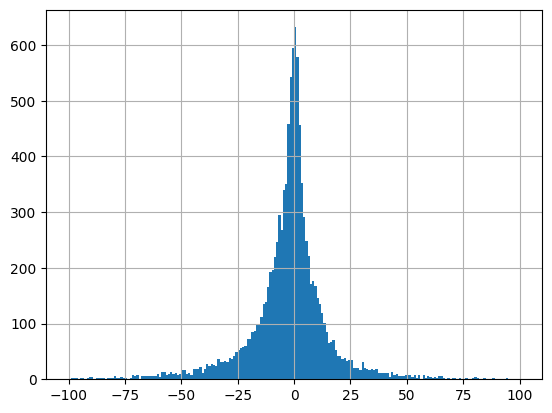

In [5]:
df['socd_change'].hist(bins=200, range = [-100,100])

In [37]:
labels = {
  '010': {'long': 'Cropland rainfed', 'short': 'CRPRF'},
  '020': {'long': 'Cropland, irrigated or post‐flooding', 'short': 'CRPIF'},
  '030': {'long': 'Mosaic cropland or natural vegetation', 'short': 'MCRNV'},
  '050': {'long': 'Tree cover broadleaved evergreen', 'short': 'TREBE'},
  '060': {'long': 'Tree cover broadleaved deciduous', 'short': 'TREBD'},
  '070': {'long': 'Tree cover needleleaved evergreen', 'short': 'TRENE'},
  '080': {'long': 'Tree cover needleleaved deciduous', 'short': 'TREND'},
  '090': {'long': 'Tree cover mixed leaf type', 'short': 'TREMX'},
  '100': {'long': 'Mosaic tree and shrub or herbaceous cover', 'short': 'MTSHH'},
  '120': {'long': 'Shrubland', 'short': 'SHRUB'},
  '130': {'long': 'Grassland', 'short': 'GRASS'},
  '140': {'long': 'Lichens and mosses', 'short': 'LICMO'},
  '150': {'long': 'Sparse vegetation', 'short': 'SPARV'},
  '160': {'long': 'Tree cover flooded', 'short': 'TREFL'},
  '180': {'long': 'Shrub or herbaceous cover flooded', 'short': 'SHHFL'},
  '190': {'long': 'Urban areas', 'short': 'URBAN'},
  '200': {'long': 'Bare areas', 'short': 'BAREA'},
  '210': {'long': 'Water bodies', 'short': 'WATER'},
  '220': {'long': 'Permanent snow and ice', 'short': 'SNWIC'}
}

def group_df(data, cvar):
    gr = data.groupby('lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052')[cvar].agg(
        positive=lambda x: (x > 100).sum(),
        neutral=lambda x: ((x >= -100) & (x <= 100)).sum(),
        negative=lambda x: (x < -100).sum(),
        mean=lambda x: np.mean(x),
        high=lambda x: np.percentile(x, 75),
        low=lambda x: np.percentile(x, 25)
    )
    # counts = data.value_counts(subset='lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052')
    # select = counts.reset_index().set_index('lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052').to_frame(name='count')
    counts = data.value_counts(subset='lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052').to_frame(name='count')
    result = counts.join(gr, rsuffix='_stat').reset_index()
    return counts.join(gr, rsuffix='x').reset_index()

def add_lcc_lbl(data):
    data['lcc6'] = data['lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052'].astype(int).astype(str).str.zfill(6)
    data['lc_from'] = data['lcc6'].str[-3:]
    data['lc_to'] = data['lcc6'].str[:3]
    data['lc_from_lbl'] = data['lc_from'].map(lambda x: labels[x]['short'])
    data['lc_to_lbl'] = data['lc_to'].map(lambda x: labels[x]['short'])
    data['lc_from_lbl_desc'] = data['lc_from'].map(lambda x: labels[x]['long'])
    data['lc_to_lbl_desc'] = data['lc_to'].map(lambda x: labels[x]['long'])
    del data['lcc6']
    return data

def add_lc_lbl(data):
    data['lc'] = data['lcc'].astype(str).str.zfill(3)
    data['lc_lbl'] = data['lc'].map(lambda x: labels[x]['short'])
    data['lc_lbl_desc'] = data['lc'].map(lambda x: labels[x]['long'])
    return data


dfc = add_lcc_lbl(df_c)
selected_lcc = dfc['lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052'].value_counts().reset_index(name='count').head(10)['lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052'].tolist()
dfc_sel = dfc.loc[dfc['lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052'].isin(selected_lcc)]

## plot separately

In [117]:
cvar = 'socd_change'
dfc_gr = group_df(df_c, cvar)

def hist_trend(data, cvar, lcc_order, trend_lim, bin_num):
    bin_edges = np.linspace(-trend_lim, trend_lim, bin_num)
    # compute histogram
    def count_values_in_bins(g):
        bins = pd.cut(g[cvar], bins=bin_edges, labels=bin_edges[:-1])
        bin_counts = bins.value_counts(normalize=True).reset_index()
        bin_counts.columns = ['bin', 'freq']
        return bin_counts
    result = data.groupby('lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052').apply(count_values_in_bins)
    result = result.reset_index().set_index('lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052').loc[lcc_order]
    del result['level_1']
    return result


def ridge_plot_lcc(data_lcc, xlim, ylim):
    import matplotlib as mpl
    import matplotlib.cm as cm
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as grid_spec
    
    data = data_lcc.groupby('lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052', sort=False)
    colors = cm.OrRd_r(np.linspace(.2, .6, len(data)))
    gs = grid_spec.GridSpec(len(data),1)
    fig = plt.figure(figsize=(5, 11))
    
    ax_objs = []
    for i, g in enumerate(data):
        d = g[1].sort_values(by='bin')
        x = d['bin'].astype(float) 
        y = d['freq']
        #y = y / y.max()

        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

        # plotting the background
        ax_objs[-1].plot(x, y, color="#f0f0f0", lw=1)
        rect = ax_objs[-1].patch
        rect.set_alpha(0)
        ax_objs[-1].set_xlim(xlim[0], xlim[1])
        ax_objs[-1].set_ylim(ylim[0], ylim[1])
        plt.tick_params(left=False)
        ax_objs[-1].set_yticklabels([])
        ax_objs[-1].set_ylabel('')
        spines = ["top","right","left","bottom"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)
        if i == len(data) - 1:
            ax_objs[-1].set_xlabel("$\Delta$SOCD ($kg/m^{3}$) 2000-2022", labelpad=20, fontsize=14)
        else:
            ax_objs[-1].set_xticklabels([])
        lcc6 = str(int(g[0])).zfill(6)
        label = labels[lcc6[-3:]]['short'] + u'\u2192' + labels[lcc6[:3]]['short']
        ax_objs[-1].text(xlim[0]*1.4, 0, label, fontsize=12, ha="center")


        # plotting data
        # ax_objs[-1].axvline(x=0, color='black', linestyle='--', linewidth=1)
        ax_objs[-1].plot([0, 0], [ylim[0], ylim[1] * 0.45], color='black', linestyle='--', linewidth=1)
        ax_objs[-1].fill_between(x, y, interpolate=True, alpha=0.8, color=colors[i])

    gs.update(hspace=-0.5)

    #fig.text(0.16, 0.89, "FAPAR trend distribution per land cover change", fontsize=20, fontweight="bold")
    # plt.savefig('fapar_trend_lc_change_ridge.pdf', format='pdf')

    plt.show()

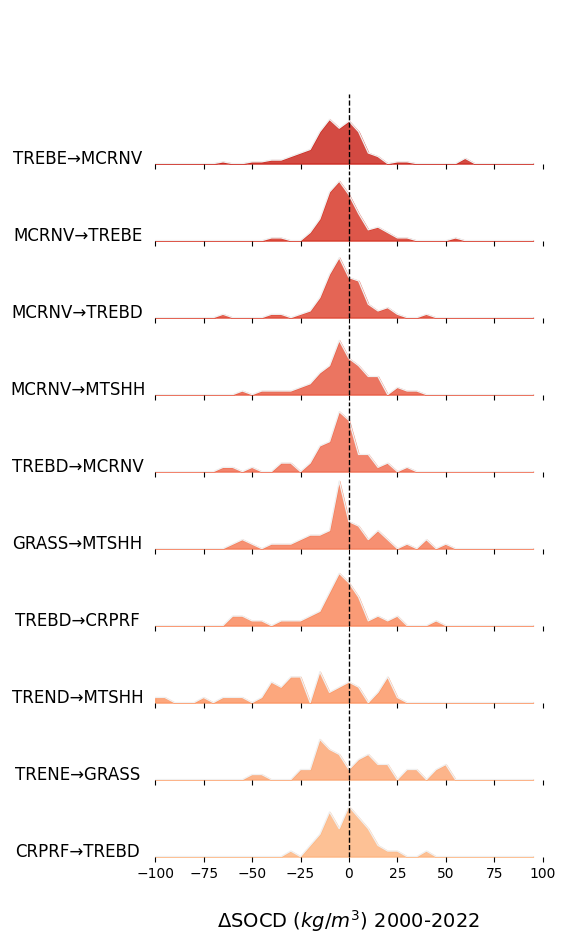

In [118]:
trend_c = hist_trend(dfc_sel, 'socd_change', dfc_gr.iloc[0:10]['lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052'], trend_lim = 100, bin_num=41)
ridge_plot_lcc(trend_c, xlim=(-100, 100), ylim=(0, 0.6))

In [141]:
cvar = 'ph.h2o_change'


def ridge_plot_lcc(data_lcc, xlim, ylim):
    import matplotlib as mpl
    import matplotlib.cm as cm
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as grid_spec
    
    data = data_lcc.groupby('lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052', sort=False)
    colors = cm.OrRd_r(np.linspace(.2, .6, len(data)))
    gs = grid_spec.GridSpec(len(data),1)
    fig = plt.figure(figsize=(5, 11))
    
    ax_objs = []
    for i, g in enumerate(data):
        d = g[1].sort_values(by='bin')
        x = d['bin'].astype(float) 
        y = d['freq']
        #y = y / y.max()

        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

        # plotting the background
        ax_objs[-1].plot(x, y, color="#f0f0f0", lw=1)
        rect = ax_objs[-1].patch
        rect.set_alpha(0)
        ax_objs[-1].set_xlim(xlim[0], xlim[1])
        ax_objs[-1].set_ylim(ylim[0], ylim[1])
        plt.tick_params(left=False)
        ax_objs[-1].set_yticklabels([])
        ax_objs[-1].set_ylabel('')
        spines = ["top","right","left","bottom"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)
        if i == len(data) - 1:
            ax_objs[-1].set_xlabel("$\Delta pH_{H2O}$ 2000-2022", labelpad=20, fontsize=14)
        else:
            ax_objs[-1].set_xticklabels([])
        lcc6 = str(int(g[0])).zfill(6)
        label = labels[lcc6[-3:]]['short'] + u'\u2192' + labels[lcc6[:3]]['short']
        ax_objs[-1].text(xlim[0]*1.4, 0, label, fontsize=12, ha="center")


        # plotting data
        # ax_objs[-1].axvline(x=0, color='black', linestyle='--', linewidth=1)
        ax_objs[-1].plot([0, 0], [ylim[0], ylim[1] * 0.45], color='black', linestyle='--', linewidth=1)
        ax_objs[-1].fill_between(x, y, interpolate=True, alpha=0.8, color=colors[i])

    gs.update(hspace=-0.5)

    #fig.text(0.16, 0.89, "FAPAR trend distribution per land cover change", fontsize=20, fontweight="bold")
    # plt.savefig('fapar_trend_lc_change_ridge.pdf', format='pdf')

    plt.show()

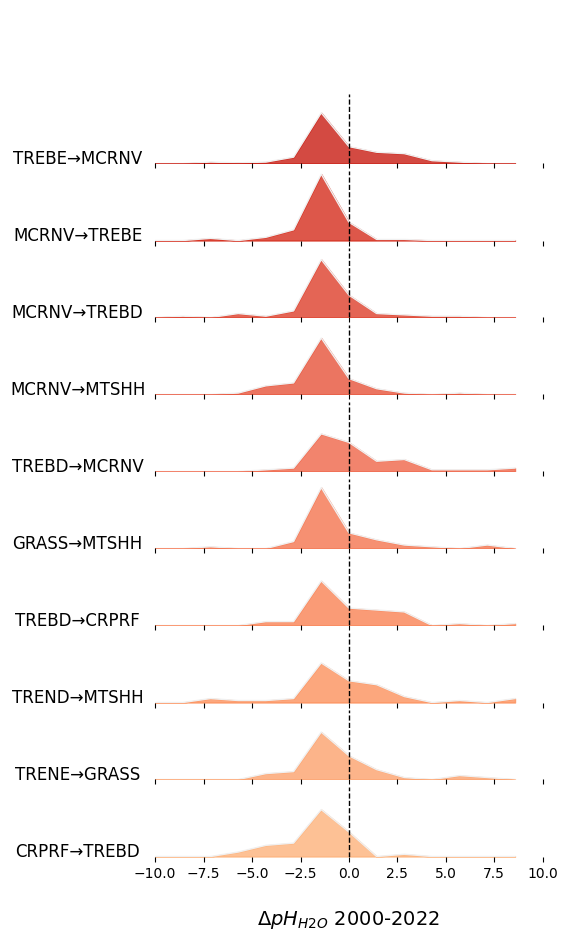

In [105]:
trend_c = hist_trend(dfc_sel, 'ph.h2o_change', dfc_gr.iloc[0:10]['lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052'], trend_lim = 10)
ridge_plot_lcc(trend_c, xlim=(-10, 10), ylim=(0, 1.5))

## combine plots

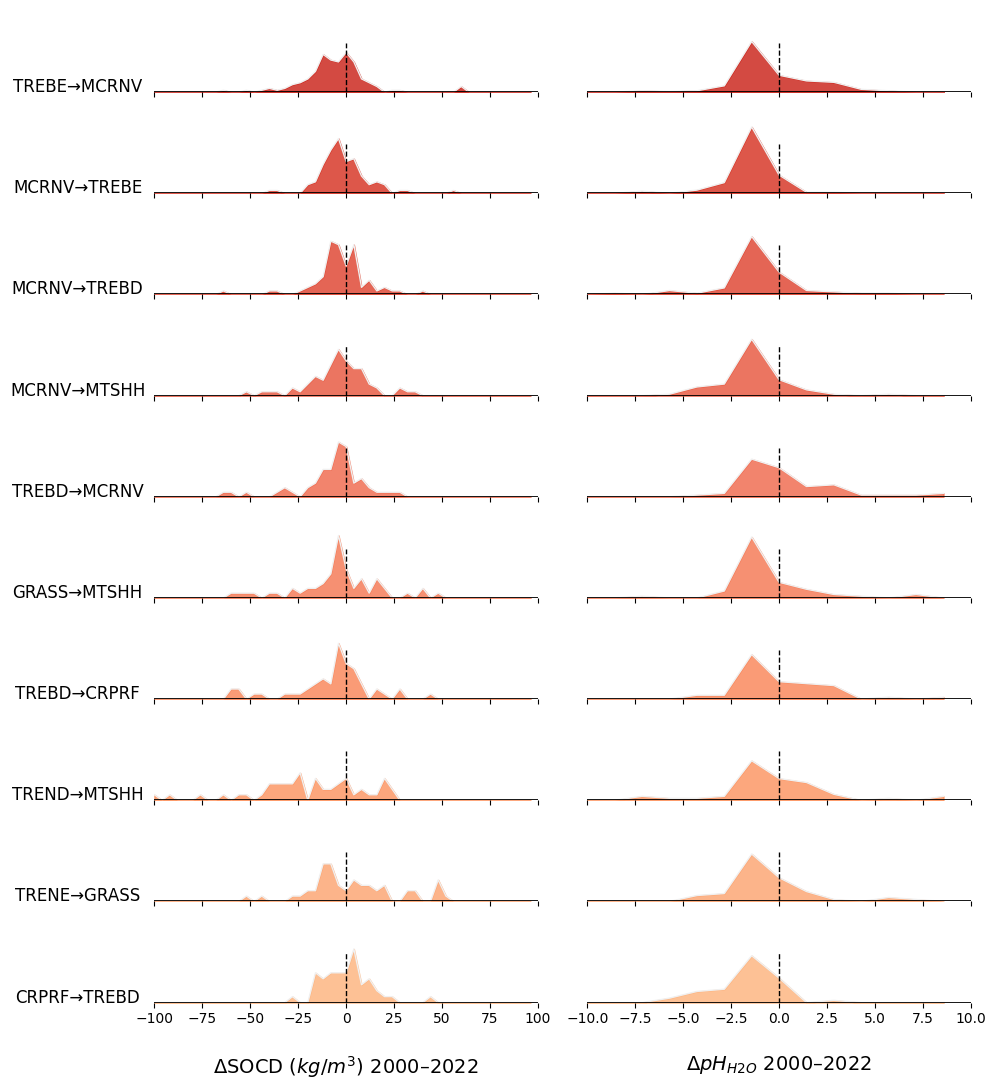

In [140]:
def ridge_plot_lcc(data_lcc, xlim, ylim, fig, ax_grid_col=0, show_label=True):
    import matplotlib.cm as cm
    import matplotlib.gridspec as grid_spec

    data = data_lcc.groupby('lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052', sort=False)
    colors = cm.OrRd_r(np.linspace(.2, .6, len(data)))
    
    gs = grid_spec.GridSpec(len(data), 2, figure=fig)  # 2 columns for side-by-side
    ax_objs = []
    
    for i, g in enumerate(data):
        d = g[1].sort_values(by='bin')
        x = d['bin'].astype(float) 
        y = d['freq']
        
        ax = fig.add_subplot(gs[i:i+1, ax_grid_col])
        ax_objs.append(ax)

        ax.plot(x, y, color="#f0f0f0", lw=1)
        ax.patch.set_alpha(0)
        ax.set_xlim(xlim[0], xlim[1])
        ax.set_ylim(ylim[0], ylim[1])
        ax.tick_params(left=False)
        ax.set_yticklabels([])
        ax.set_ylabel('')
        for s in ["top","right","left","bottom"]:
            ax.spines[s].set_visible(False)
        if i == len(data) - 1:
            if ax_grid_col == 0:
                ax.set_xlabel("$\Delta$SOCD ($kg/m^{3}$) 2000–2022", labelpad=20, fontsize=14)
            else:
                ax.set_xlabel("$\Delta pH_{H2O}$ 2000–2022", labelpad=20, fontsize=14)
        else:
            ax.set_xticklabels([])

        if show_label and ax_grid_col == 0:
            lcc6 = str(int(g[0])).zfill(6)
            label = labels[lcc6[-3:]]['short'] + u'\u2192' + labels[lcc6[:3]]['short']
            ax.text(xlim[0]*1.4, 0, label, fontsize=12, ha="center")

        # vertical dashed line
        ax.plot([0, 0], [ylim[0], ylim[1] * 0.6], color='black', linestyle='--', linewidth=1)
        ax.plot([0, 1], [0, 0], transform=ax.transAxes, color='black', linewidth=2)
        ax.fill_between(x, y, interpolate=True, alpha=0.8, color=colors[i])

        
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig = plt.figure(figsize=(10, 11))  # wider figure for side-by-side

# First ridge plot: SOCD
cvar = 'socd_change'
dfc_gr = group_df(df_c, cvar)
trend_c = hist_trend(dfc_sel, cvar, dfc_gr.iloc[0:10]['lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052'], trend_lim=100, bin_num=51)
ridge_plot_lcc(trend_c, xlim=(-100, 100), ylim=(0, 0.3), fig=fig, ax_grid_col=0, show_label=True)

# Second ridge plot: pH
cvar = 'ph.h2o_change'
dfc_gr = group_df(df_c, cvar)
trend_c = hist_trend(dfc_sel, cvar, dfc_gr.iloc[0:10]['lcv_land.cover_esacci.lc.l4.aggcl.change_c_250m_s0..0cm_2000_2020_v1.0.epsg.54052'], trend_lim=10, bin_num=15)
ridge_plot_lcc(trend_c, xlim=(-10, 10), ylim=(0, 0.8), fig=fig, ax_grid_col=1, show_label=False)

import matplotlib.patches as patches

plt.tight_layout()
plt.savefig('Fig_soil.prop_lc.change_ridge.pdf', format='pdf')
plt.show()
